In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [4]:
import torch
import torchvision
torch.__version__
#重要参数
n_epochs = 3 #迭代轮数
batch_size_train = 64 #训练集规模
batch_size_test = 1000 #测试集规模
learning_rate = 0.01 #学习率

#一般参数
momentum = 0.5 #动量系数
log_interval = 10 #控制可视化输出间隔

random_seed = 1 
#是否使用非确定性算法，True时会自动寻找适合当前的高效算法。
torch.backends.cudnn.enabled = False 
torch.manual_seed(random_seed) #设置随机种子


In [5]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True, #MNIST下载数据
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
    batch_size=batch_size_test, shuffle=True)
examples = enumerate(train_loader) #获取一个batch（样本数量，通道，28,28维）
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape
torch.Size([64, 1, 28, 28])


torch.Size([64, 1, 28, 28])

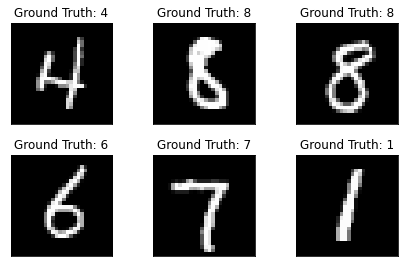

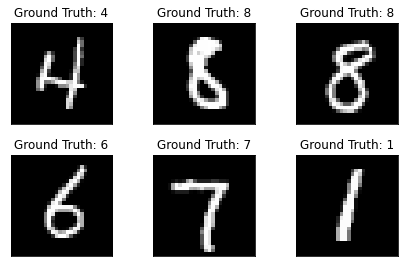

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig


In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [8]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) #卷积层
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv3 = nn.Conv2d(20,50, kernel_size=2)
        self.conv2_drop = nn.Dropout2d()
        self.conv3_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(200, 50)
        self.fc2 = nn.Linear(50, 10) #全连接层

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #drop不改变维度随机删去一些数据
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        x = x.view(-1, 200) #view将数据变为200维的数据
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)


In [9]:
network = MNISTNet()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)


In [10]:
train_losses = []
train_counter = [] #训练损失对应的时间点
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]


In [11]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  #初始化优化器
        output = network(data) #实例化网络
        loss = F.nll_loss(output, target)
        loss.backward()        #反向回传
        optimizer.step()	   #迭代参数
        
        #以下为结果输出格式调整
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            #注意这里的network.state_dict()是用来保存中间的训练状态的，
            #保存后，以后可以从任何一步开始重新训练网络
            torch.save(network.state_dict(), 'D:/liuchaochao/桌面/中间过程/model.pth') #注意 # 保存中间过程
            torch.save(optimizer.state_dict(), 'D:/liuchaochao/桌面/中间过程/optimizer.pth') 


In [12]:
def test(): 
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():#特使不需要回传梯度
        for data, target in test_loader:
            output = network(data)
            #计算损失
            test_loss += F.nll_loss(output, target, size_average=False).item()
            #计算准确数
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))


In [13]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


D:\liuchaochao\DownLoad\anaconda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3059, Accuracy: 1014/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302437
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.293808
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.307121
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.290816
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.354150
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.302542
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.313314
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.302453
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.273012
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.294048
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.325958
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.315298
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.324537
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.293900
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.300088
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.304446
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.300995
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.271881
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.277681
Train Epoch: 1 [12160

Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.791377
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.782867
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.597625
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.644302
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.710607
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.899723
Train Epoch: 2 [48640/60000 (81%)]	Loss: 1.023205
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.936285
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.548621
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.613390
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.374630
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.815759
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.476672
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.724518
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.688612
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.531284
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.524691
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.790178
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.512978
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.696899


In [14]:
import torch
 
pthfile = r'D:/liuchaochao/桌面/中间过程/model.pth'            #.pth文件的路径
#D:/liuchaochao/桌面/中间过程/model.pth') #注意 # 保存中间过程
#torch.save(optimizer.state_dict(), 'D:/liuchaochao/桌面/中间过程/optimizer.pth')
model = torch.load(pthfile, torch.device('cpu'))    #设置在cpu环境下查询
print('type:')
print(type(model))  #查看模型字典长度
print('length:')
print(len(model))
print('key:')
for k in model.keys():  #查看模型字典里面的key
    print(k)
print('value:')
for k in model:         #查看模型字典里面的value
    print(k,model[k])

type:
<class 'collections.OrderedDict'>
length:
10
key:
conv1.weight
conv1.bias
conv2.weight
conv2.bias
conv3.weight
conv3.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
value:
conv1.weight tensor([[[[-0.2977,  0.0379, -0.0112,  0.2403,  0.1651],
          [-0.1491, -0.0432, -0.0060,  0.1909,  0.0585],
          [-0.1548, -0.0922,  0.0522,  0.1552,  0.2579],
          [-0.0525, -0.1180, -0.0168,  0.1954,  0.0453],
          [-0.1618, -0.0781,  0.1500,  0.3322, -0.0334]]],


        [[[ 0.1326,  0.2017,  0.2598,  0.1209, -0.1647],
          [-0.2437,  0.0007,  0.3400,  0.2183,  0.2848],
          [-0.1876,  0.1699,  0.0412,  0.3075,  0.1950],
          [-0.3007, -0.0787, -0.2036, -0.0666, -0.0463],
          [-0.2485, -0.4048, -0.2947, -0.1094, -0.0841]]],


        [[[ 0.2674,  0.3154,  0.1233, -0.0258,  0.2667],
          [ 0.0476,  0.0023,  0.2484,  0.2129,  0.3101],
          [-0.2028, -0.0469, -0.0593, -0.0403, -0.1202],
          [-0.2556, -0.0430, -0.2105, -0.0299,  0.0201],
      

In [15]:
import torch
 
pthfile = r'D:/liuchaochao/桌面/中间过程/optimizer.pth'            #.pth文件的路径
#D:/liuchaochao/桌面/中间过程/model.pth') #注意 # 保存中间过程
#torch.save(optimizer.state_dict(), 'D:/liuchaochao/桌面/中间过程/optimizer.pth')
model = torch.load(pthfile, torch.device('cpu'))    #设置在cpu环境下查询
print('type:')
print(type(model))  #查看模型字典长度
print('length:')
print(len(model))
print('key:')
for k in model.keys():  #查看模型字典里面的key
    print(k)
print('value:')
for k in model:         #查看模型字典里面的value
    print(k,model[k])

type:
<class 'dict'>
length:
2
key:
state
param_groups
value:
state {0: {'momentum_buffer': tensor([[[[-0.0210, -0.0177, -0.0091,  0.0354,  0.0431],
          [-0.0294, -0.0067,  0.0071,  0.0251,  0.0200],
          [-0.0228, -0.0081, -0.0021,  0.0291,  0.0211],
          [-0.0053,  0.0069,  0.0192,  0.0475,  0.0326],
          [ 0.0170,  0.0109,  0.0209,  0.0543,  0.0589]]],


        [[[ 0.0528,  0.0375,  0.0358, -0.0145, -0.0653],
          [ 0.0206,  0.0127, -0.0011, -0.0470, -0.0765],
          [ 0.0264,  0.0310,  0.0121, -0.0451, -0.0704],
          [ 0.0668,  0.0475,  0.0169, -0.0256, -0.0612],
          [ 0.0623,  0.0377, -0.0014, -0.0106, -0.0607]]],


        [[[ 0.0246,  0.0312,  0.0282,  0.0070, -0.0004],
          [-0.0106,  0.0017,  0.0151,  0.0110, -0.0048],
          [-0.0069, -0.0042, -0.0036,  0.0060, -0.0054],
          [ 0.0168,  0.0032, -0.0027, -0.0028, -0.0172],
          [ 0.0106, -0.0104, -0.0161, -0.0262, -0.0460]]],


        [[[-0.0165, -0.0251, -0.0159, -0.